In [1]:
import gymnasium as gym
import gym_trading_env
import yfinance as yf
from pprint import pprint
import matplotlib.pyplot as plt
from stable_baselines3 import PPO, A2C, DDPG, TD3
import pandas as pd
from preprocessors import FeatureEngineer
from yahoodownloader import YahooDownloader
import numpy as np
from env import StockTradingEnv
%matplotlib inline

In [2]:
stock_name = "MSFT"
start_date_train = "2015-01-01"
end_date_train = "2020-01-01"
start_date_test = "2020-01-01"
end_date_test = "2021-01-01"

timesteps = 1e5

In [3]:
def get_data(stock_name, start_date, end_date):
    df = yf.download(stock_name, start=start_date, end=end_date)
    df = df.reset_index()
    df.columns = [x.lower() for x in df.columns]
    df = df.dropna()
    return df

In [4]:
DOW_30_TICKER = [
    "AXP",
    "AMGN",
    "AAPL",
    "BA",
    "CAT",
    "CSCO",
    "CVX",
    "GS",
    "HD",
    "HON",
    "IBM",
    "INTC",
    "JNJ",
    "KO",
    "JPM",
    "MCD",
    "MMM",
    "MRK",
    "MSFT",
    "NKE",
    "PG",
    "TRV",
    "UNH",
    "CRM",
    "VZ",
    "V",
    "WBA",
    "WMT",
    "DIS",
    "DOW",
]

In [5]:
df_train = YahooDownloader(start_date=start_date_train,
                     end_date = end_date_train,
                     ticker_list = [stock_name]).fetch_data()
df_test = YahooDownloader(start_date=start_date_test,
                        end_date = end_date_test,
                        ticker_list = [stock_name]).fetch_data()

[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (1258, 8)
[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (253, 8)


In [6]:
INDICATORS = [
    "macd",
    "boll_ub",
    "boll_lb",
    "rsi_30",
    "cci_30",
    "dx_30",
    "close_30_sma",
    "close_60_sma",
]

In [7]:
def add_indicators(df):
    fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)
    processed = fe.preprocess_data(df)
    processed = processed.copy()
    processed = processed.fillna(0)
    processed = processed.replace(np.inf,0)
    return processed

In [8]:
df_train = add_indicators(df_train)
df_test = add_indicators(df_test)

Successfully added technical indicators
Successfully added turbulence index
Successfully added technical indicators
Successfully added turbulence index


In [9]:
df_train.tail()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
1253,2019-12-24,157.479996,157.710007,157.119995,151.657333,8989200,MSFT,1,2.543138,152.644912,142.284196,67.776728,163.025646,29.852905,146.171390,140.557934,0.026979
1254,2019-12-26,157.559998,158.729996,157.399994,152.900436,14520600,MSFT,3,2.644967,153.479290,142.089676,69.225107,166.675419,32.424276,146.560017,140.912309,0.207937
1255,2019-12-27,159.449997,159.550003,158.220001,153.179916,18412800,MSFT,4,2.716900,154.262056,141.946768,69.543498,162.912909,34.423444,146.950278,141.310077,0.000092
1256,2019-12-30,158.990005,159.020004,156.729996,151.859695,16348400,MSFT,0,2.636979,154.685548,142.121696,66.196779,121.692768,27.341973,147.272521,141.659752,0.711847
1257,2019-12-31,156.770004,157.770004,156.449997,151.965668,18369400,MSFT,1,2.552766,154.928772,142.663830,66.331321,100.386772,26.051091,147.537154,141.981741,0.009664


In [10]:
stock_dimension = len(df_train.tic.unique())
state_space = 1 + 2 * stock_dimension + len(INDICATORS) * stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

initial_amount = 1000000
env_kwargs = {
    "hmax": 100,
    "initial_amount": initial_amount,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
}

Stock Dimension: 1, State Space: 11


In [11]:
env_train = StockTradingEnv(df=df_train, **env_kwargs)
env_train.make_plots = True

env_test = StockTradingEnv(df=df_test, **env_kwargs)
env_test.make_plots = True

In [12]:
def simulate(env,models = None):
    observation, info = env.reset()
    truncated, done = False, False
    history = []
    while not done:
        action = None
        if models:
            action = 0
            if(type(models) != list):
                models = [models]
            for model in models:
                action += model.predict(observation)[0]
            action /= len(models)
        else:
            action = env.action_space.sample()
        observation, reward, done, truncated, info = env.step(action)
        if truncated:
            break
        history.append(observation)
    return history

In [13]:
def plot_env(env):
    df = env.df
    close = np.array(df['close'])
    dates = range(len(close))
    valuation = env.asset_memory
    actions = [0] + list(map(lambda x: x[0], env.actions_memory))
    fig, ax1 = plt.subplots(figsize=(15, 8))
    ax1.plot(dates, close)
    ax1.set_xlabel('date')
    ax1.set_ylabel('price')
    ax1.scatter(dates, close, c=actions)
    fig.tight_layout()
    plt.show()
    
    print("Total return: ", (valuation[-1] - valuation[0]) / valuation[0])
    print("Buy and hold return: ", (close[-1] - close[0]) / close[0])

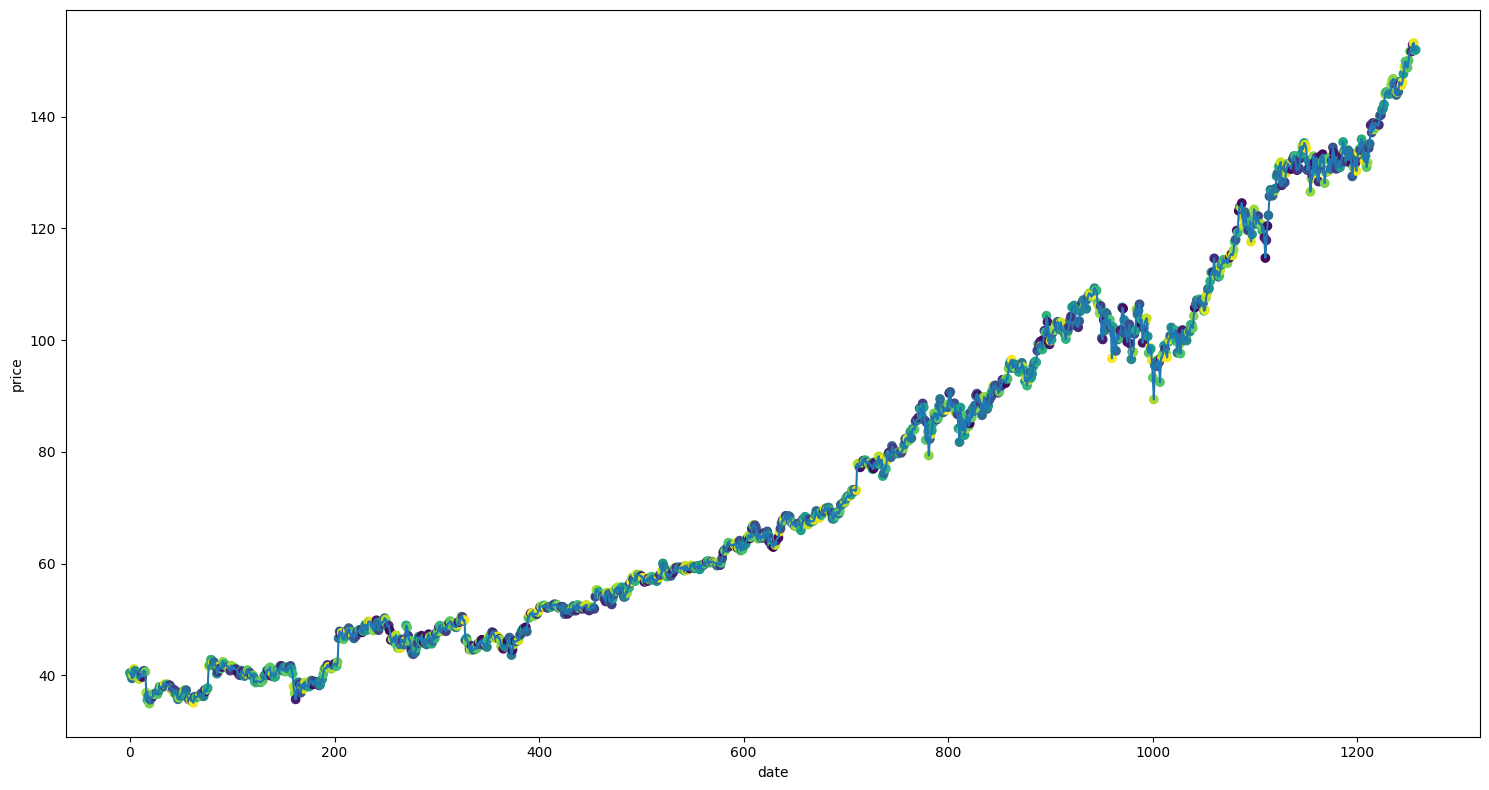

Total return:  0.1943638211036995
Buy and hold return:  2.7566223893136113


In [14]:
history = simulate(env_train)
plot_env(env_train)

In [15]:
model = PPO('MlpPolicy', env_train, verbose=1, n_epochs=20)
model.learn(total_timesteps=timesteps)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.26e+03 |
|    ep_rew_mean     | 8.51     |
| time/              |          |
|    fps             | 1382     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.26e+03   |
|    ep_rew_mean          | 21.9       |
| time/                   |            |
|    fps                  | 863        |
|    iterations           | 2          |
|    time_elapsed         | 4          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.00554075 |
|    clip_fraction        | 0.0322     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.41

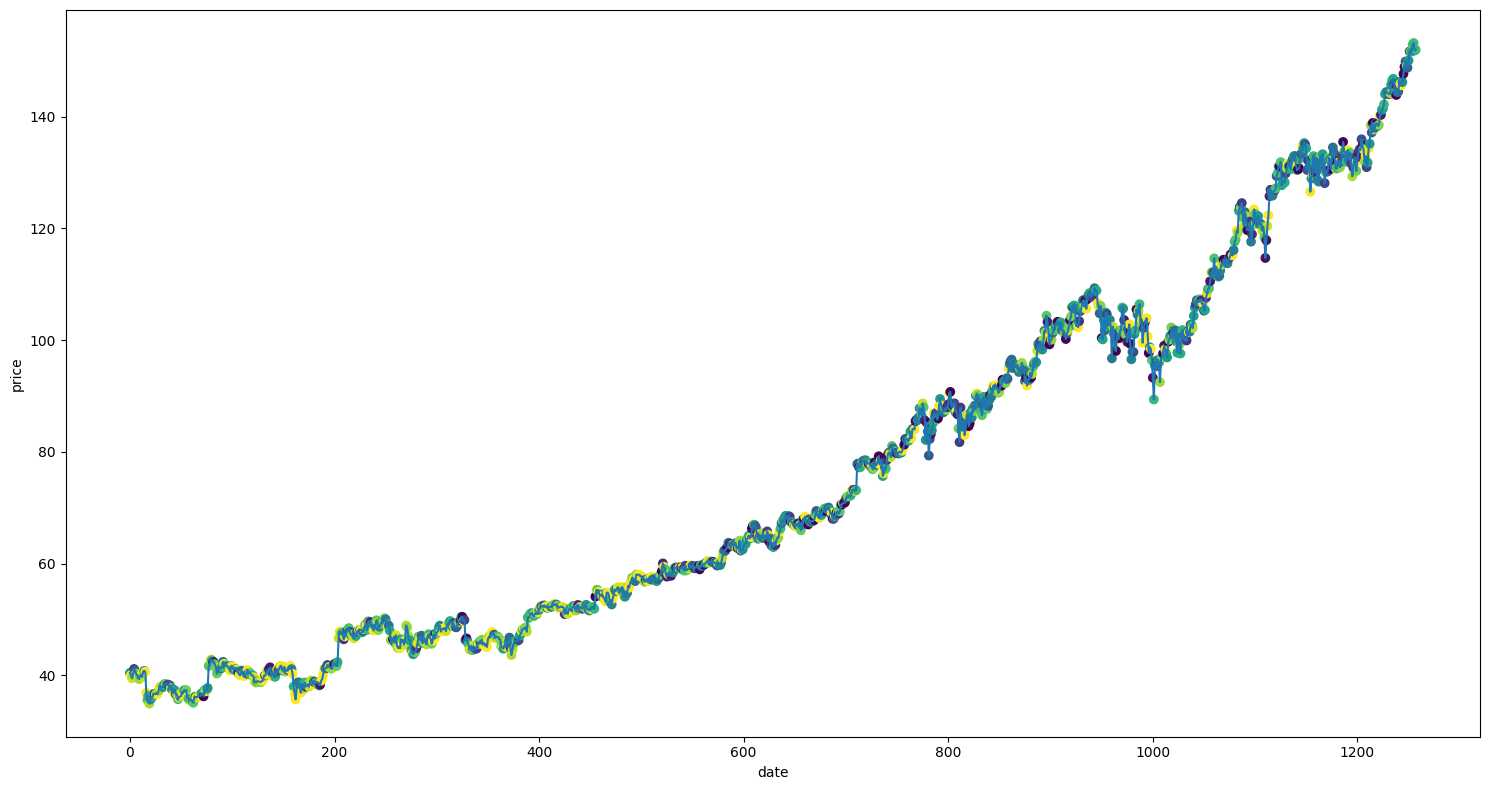

Total return:  2.235229585173413
Buy and hold return:  2.7566223893136113


In [16]:
history = simulate(env_train, model)
plot_env(env_train)

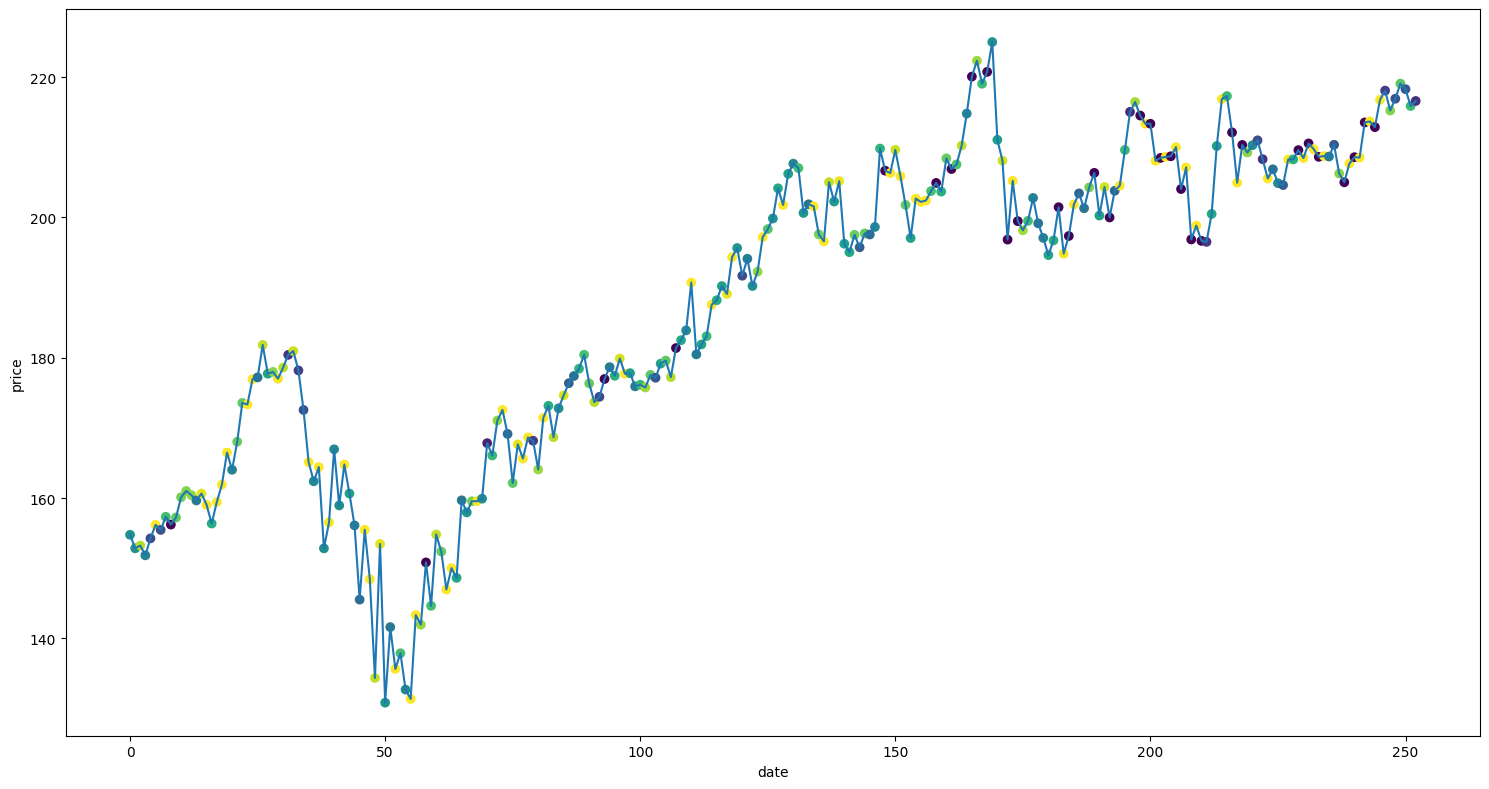

Total return:  0.24945951344638062
Buy and hold return:  0.3994287055028624


In [17]:
history = simulate(env_test, model)
plot_env(env_test)

In [18]:
a2c_model = A2C('MlpPolicy', env_train, verbose=1)
ppo_model = PPO('MlpPolicy', env_train, verbose=1)
ddpg_model = DDPG('MlpPolicy', env_train, verbose=1)
td3_model = TD3('MlpPolicy', env_train, verbose=1)


models = [a2c_model, ppo_model, ddpg_model, td3_model]
for model in models:
    model.learn(total_timesteps=timesteps)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-------------------------------------
| time/                 |           |
|    fps                | 996       |
|    iterations         | 100       |
|    time_elapsed       | 0         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -1.42     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | -0.0021   |
|    std                | 0.998     |
|    value_loss         | 3.44e-06  |
-------------------------------------
------------------------------------
| time/          

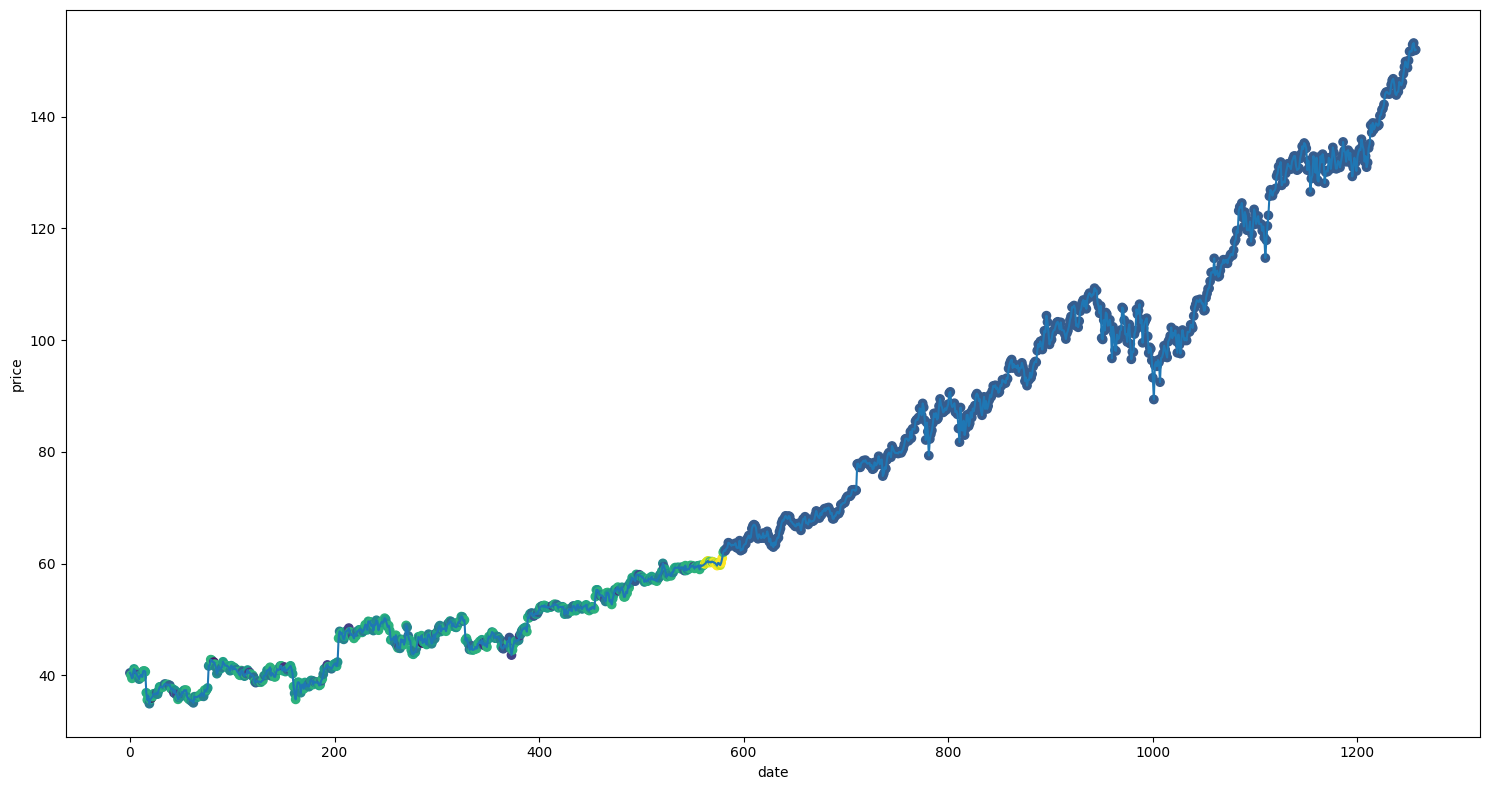

Total return:  2.1663771353106394
Buy and hold return:  2.7566223893136113


In [19]:
history = simulate(env_train, models)
plot_env(env_train)

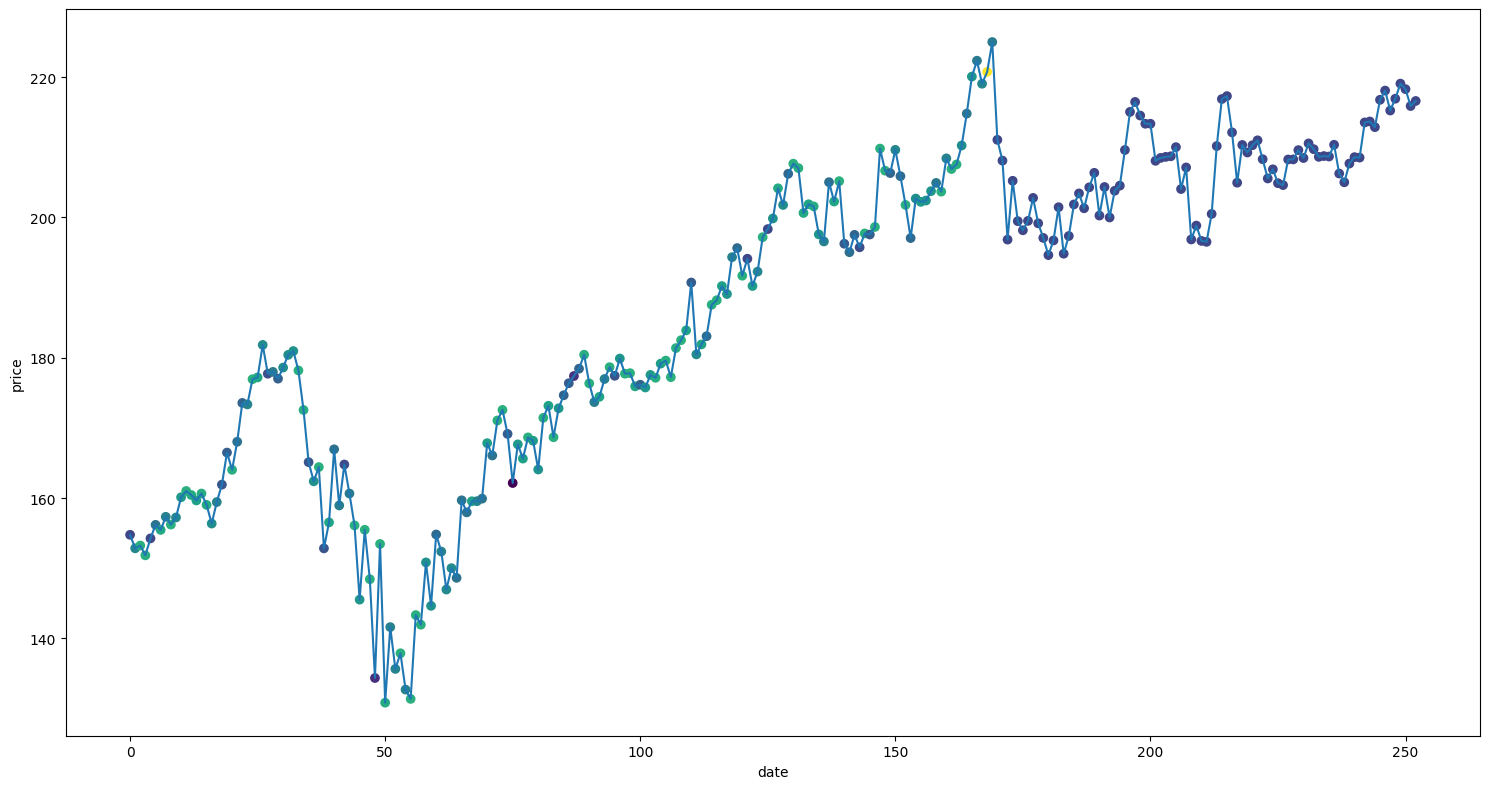

Total return:  0.22121447402853378
Buy and hold return:  0.3994287055028624


In [20]:
history = simulate(env_test, models)
plot_env(env_test)